# Project: Measuring impact of green infrastructure projects on stormwater capture in urban environments 

This project has the following goals:
1. Measure the role and impact of green infrastructure (GI) projects on stormwater capture and discharge in an urban area

2. Measure the change in urban greenspace over time and analyze how stormwater capture/dischage rates correlate with these changes

In [17]:
import os
import earthpy as et

from PIL import Image

# Import Packages
# %run functions.ipynb

from glob import glob
from datetime import datetime
import nbconvert

import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em

import scipy.stats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger

from itertools import groupby
    
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping
import numpy.ma as ma
from rasterio.plot import plotting_extent
import rasterstats as rs
from shapely.geometry import box

%matplotlib inline

# Download data and set working directory
os.chdir(os.path.join(et.io.HOME, 
                      'earth-analytics', 
                      'urban-stormwater-capture'))

## What is a Green Infrastucture Project?  
Green infrastructure projects are geo-engineered features that help redirect and recapture stormwater runoff from urban hardscapes 

GI projects can be site-scale projects such as water retention ponds and bioswales, or urban-scale projects such as greenways and infiltration catchment areas to help: 
- More effectively recapture groundwater resources
- Help flatten spikes in peak flow volumes after heavy precipitation
- Reduce pollutant discharge into local water systems 

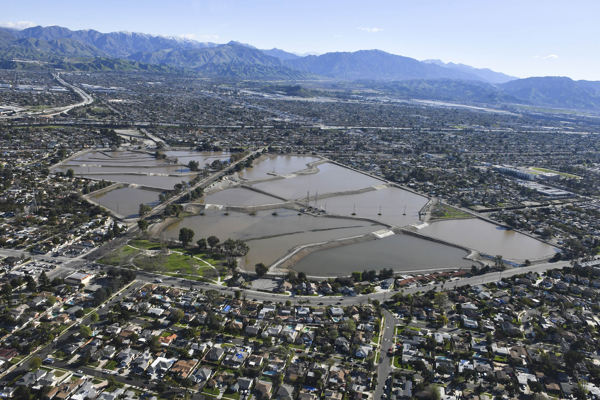

In [18]:
image = Image.open(os.path.join("graphics",
                                "Pacoima-SG1.jpg"))

image.thumbnail((600, 600))
image.save('image_thumbnail.jpg')

image

## How will these be measured? 

To view the impact of green infrastucture projects on stormwater capture, we will use Sentinel-2 bands to calculate the Normalized Difference Moisture Index (NDMI) to measure the moisture content of both project areas and the surrounding region. 

*NDMI = (Band 8 (NIR) – Band 11 (SWIR)) / (Band 8 (NIR) + Band 11 (SWIR))*

Ideally, these project areas will show greater effectivness in capturing and retaining stormwater runoff via more saturated soils. 

## How exactly does NDMI correlate with moisture levels? 

This table below shows how the NDMI measurement relates to different levels of soil saturation, vegetation, and/or water stress for a given area:

| NDMI | Interpretation |
|   :---   |   :---  |
|-1 – -0.8 |Bare soil |
|-0.8 – -0.6 | Almost absent canopy cover |
|-0.6 – -0.4 | Very low canopy cover |
|-0.4 – -0.2 |Low canopy cover, dry or very low canopy cover, wet |
|-0.2 – 0 |Mid-low canopy cover, high water stress or low canopy cover, low water stress |
|0 – 0.2 |Average canopy cover, high water stress or mid-low canopy cover, low water stress |
|0.2 – 0.4 |Mid-high canopy cover, high water stress or average canopy cover, low water stress |
|0.4 – 0.6 |High canopy cover, no water stress |
|0.6 – 0.8 |Very high canopy cover, no water stress |
|0.8 – 1 |Total canopy cover, no water stress/waterlogging |

## Where is our project area? 
This analysis will focus on the Los Angeles metro area and several green infrastructure projects such as stormwater spreading grounds

In [19]:
import folium 
la_map = folium.Map(location=[34.0522, -118.2437])
la_map

## Prep Step #2: Set up required data paths for analysis 

In [20]:
# set up paths to data

# LA spreading grounds shapefiles
shape_spread_path = os.path.join("data",
                                 "la-spreading-grounds",
                                 "Spreading_Grounds_Feature_Layer.shp")                                 
shape_spread_data = gpd.read_file(shape_spread_path)

#LA catchment areas shapefiles
shape_catchment_path = os.path.join("data",
                                    "la-catchment-areas",
                                    "Los_Angeles_County_Catchment_Areas.shp")                                 
shape_catchment_data = gpd.read_file(shape_catchment_path)

#LA area region crop 
la_crop_path = os.path.join("data",
                       "Sentinel-2-Shapefile-Index",
                       "sentinel_2_index_shapefile.shp")

la_crop_data = gpd.read_file(la_crop_path).loc[
                                            gpd.read_file(la_crop_path)["Name"]=="11SLT"]

#City boundaries shapefiles

city_boundaries_path = os.path.join("data",
                                    "la-city-boundaries",
                                    "City_Boundaries.shp")   

city_boundaries_data = gpd.read_file(city_boundaries_path)

#LA streams and rivers shapefiles 
la_streams_rivers_path = os.path.join("data",
                                     "la-streams-rivers",
                                     "geo_export_339f28ec-e123-431b-a506-4d994dfd8153.shp")
la_streams_rivers_data = gpd.read_file(la_streams_rivers_path)


#Sentinel-2 data paths
sent_jan_2022_path = os.path.join("data", 
                                  "sent-jan-2022")
sent_jul_2021_path = os.path.join("data", 
                                  "sent-jul-2021")

sent_all_2021_path = os.path.join("data", 
                                  "sent-all-2021")

#Select path that will be used primarily for analysis
sent_path = os.path.join(sent_all_2021_path)

#Paths to access NIR (Band 8) and SWIR (Band 11) 
band_8_paths = glob(os.path.join(sent_path,"*B08*.tif")) 
band_11_paths = glob(os.path.join(sent_path,"*B11*.tif"))
qa_layer_paths = glob(os.path.join(sent_path,"*Fmask*.tif"))

ndmi_band_paths = band_8_paths + band_11_paths

## Prep Step #3: Create functions needed to open clean, cloud masked bands

### Follow Sentinel-2 HLS documentation to create masking value references ## 

Git: https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/HLS_Tutorial.ipynb#processhls

In [21]:
def cloud_mask (fmask):
    
    """
    Create bit dictionary and map Sentinel-2 HLS quality assurance (QA) layers from bits
    

    """

    # bitword dictionaries 

    bitword_order = (1, 1, 1, 1, 1, 1, 2)  # set the number of bits per bitword
    num_bitwords = len(bitword_order)      # Define the number of bitwords based on your input above
    total_bits = sum(bitword_order)        # Should be 8, 16, or 32 depending on datatype

    # Loop to create cloud mask lookup from Git documentation 

    qVals = list(np.unique(fmask))  # Create a list of unique values that need to be converted to binary and decoded

    all_bits = list()
    summary_bits=list()

    goodQuality = []
    for v in qVals:
        all_bits = []
        bits = total_bits
        i = 0

        # Convert to binary based on the values and # of bits defined above:
        bit_val = format(v, 'b').zfill(bits)
        print('\n' + str(v) + ' = ' + str(bit_val))
        all_bits.append(str(v) + ' = ' + str(bit_val))

        # Go through & split out the values for each bit word based on input above:
        for b in bitword_order:
            prev_bit = bits
            bits = bits - b
            i = i + 1
            if i == 1:
                bitword = bit_val[bits:]
                print(' Bit Word ' + str(i) + ': ' + str(bitword))
                all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword)) 
            elif i == num_bitwords:
                bitword = bit_val[:prev_bit]
                print(' Bit Word ' + str(i) + ': ' + str(bitword))
                all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))
            else:
                bitword = bit_val[bits:prev_bit]
                print(' Bit Word ' + str(i) + ': ' + str(bitword))
                all_bits.append(' Bit Word ' + str(i) + ': ' + str(bitword))

#         2, 4, 5, 6, and 7 are the bits used. All 5 should > 1 if pixels are not clouds, cloud shadows, snow/ice/water, and aerosols
        if (int(all_bits[2].split(': ')[-1]) + int(all_bits[4].split(': ')[-1]) + \
                int(all_bits[5].split(': ')[-1]) + int(all_bits[6].split(': ')[-1])) == 0 and \
                int(all_bits[7].split(': ')[-1]) < 11:
    
#     + int(all_bits[7].split(': ')[-1]) == 1:
    
            goodQuality.append(v)

    # test values that do not need to be masked 
    return goodQuality

In [22]:
def open_clean_bands(band_path,
                     crop_bound,
                     valid_range,
                    pixel_qa_path):
    
    """
    Open, clean, and crop a file into an xarray DataArray.

    Parameters
    -----------
    band_path:string
        A path to the array to be opened
    crop_bound:geopandas GeoDataFrame
        A geopandas dataframe to be used to crop the raster data using rioxarray clip().
    valid_range:tuple (optional)
         A tuple of min and max range of values for the data. Default = None

    Returns
    -----------

    band : xarray DataArray
        End result for a cropped xarray dataarray
    """

    crop_bound_box = [box(*crop_bound.total_bounds)]

    try:
        band = rxr.open_rasterio(band_path,
                                 masked=True).rio.clip(
                                                        crop_bound_box,
                                                        crs=crop_bound.crs,
                                                        all_touched=True,
                                                        from_disk=True).squeeze()
    
        mask = ((band < valid_range[0]) | (band > valid_range[1]))
        band = band.where(~xr.where(mask, True, False))

        # open and mask cloud layer
        cl_mask = (rxr.open_rasterio(pixel_qa_path, masked=True)
                        .rio.clip(
                            crop_bound_box,
                            from_disk=True).squeeze())

        # apply cloud mask
        band = band.where(cl_mask.isin(goodQuality)).squeeze()
        
    except:
        raise ValueError(
            "Oops - I couldn't clip your data. This may be due to a crs error.")

    return band, cl_mask

## Prep Step #4: Create necessary crop bounds using site, city, and project area shapefiles  ##

- Site area = Los Angeles County (MGRS: 11SLT) 
- Project area = Eaton Spreading Grounds
- Related city area for Eaton Spreading Grounds = Pasadena, CA

In [23]:
# test bands for a single site 

#band 8
test_tif_8 = os.path.join("data",
                          "sent-all-2021",
                        "HLS.S30.T11SLT.2021008T183739.v2.0.B08.tif")

#band 11
test_tif_11 = os.path.join("data", 
                           "sent-all-2021",
                        "HLS.S30.T11SLT.2021008T183739.v2.0.B11.tif")

#create rasters for bands 8 and 11
test_rxr_8 = rxr.open_rasterio(test_tif_8,masked=True).squeeze()


test_rxr_11 = rxr.open_rasterio(test_tif_11,masked=True).squeeze()


In [24]:
#reproject shape files to crs 
la_reproj_crop = la_crop_data.to_crs(test_rxr_11.rio.crs)

#spreading ground reprojections for Eaton Spreading Grounds

spreading_shape_reproj = shape_spread_data.to_crs(test_rxr_11.rio.crs)

eaton_shape = spreading_shape_reproj.loc[
                                        spreading_shape_reproj['NAME'] == "EATON S.G."]

#Reprojections for other potential shapefiles 

la_streams_rivers_reproj = la_streams_rivers_data.to_crs(test_rxr_11.rio.crs)

city_boundaries_reproj = city_boundaries_data.to_crs(test_rxr_11.rio.crs)
pasadena_shape = city_boundaries_reproj.loc[
                                        city_boundaries_reproj['CITY_NAME'] == "Pasadena"]

#create plot extents for site (LA) and project area (Eaton SG)

la_plot_extent = plotting_extent(test_rxr_11, 
                                   test_rxr_11.rio.transform())

eaton_shape

,OBJECTID,ID,NAME,OWNER_OPER,BASIN_TYPE,NO__OF_BAS,SEASON_FIR,GROSS_AREA,WETTED_ARE,CHANNEL,INTAKES,STORAGE,PERCOLATIO,CONTROLLED,UNCONTROLL,EQNUM,MXCREATION,SHAPEAREA,SHAPELEN,geometry
34,35,W,EATON S.G.,LOS ANGELES COUNTY - DPW,DEEP & SHALLOW,14,1947-48,28 ACRES,25.0 ACRES,6600 CFS,200 CFS,525 AF,14 CFS,EATON WASH DAM,IMPORTED WATER,None,1,5.282895e+06,25754.052128,"MULTIPOLYGON (((399200.586 3781846.894, 399202..."


## Prep Step #5: Create Cloud Mask Layers 


64 = 01000000
 Bit Word 1: 0
 Bit Word 2: 0
 Bit Word 3: 0
 Bit Word 4: 0
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

66 = 01000010
 Bit Word 1: 0
 Bit Word 2: 1
 Bit Word 3: 0
 Bit Word 4: 0
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

68 = 01000100
 Bit Word 1: 0
 Bit Word 2: 0
 Bit Word 3: 1
 Bit Word 4: 0
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

70 = 01000110
 Bit Word 1: 0
 Bit Word 2: 1
 Bit Word 3: 1
 Bit Word 4: 0
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

72 = 01001000
 Bit Word 1: 0
 Bit Word 2: 0
 Bit Word 3: 0
 Bit Word 4: 1
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

74 = 01001010
 Bit Word 1: 0
 Bit Word 2: 1
 Bit Word 3: 0
 Bit Word 4: 1
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

76 = 01001100
 Bit Word 1: 0
 Bit Word 2: 0
 Bit Word 3: 1
 Bit Word 4: 1
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

78 = 01001110
 Bit Word 1: 0
 Bit Word 2: 1
 Bit Word 3: 1
 Bit Word 4: 1
 Bit Word 5: 0
 Bit Word 6: 0
 Bit Word 7: 01

80 = 01010000
 Bit Word 1: 0
 B

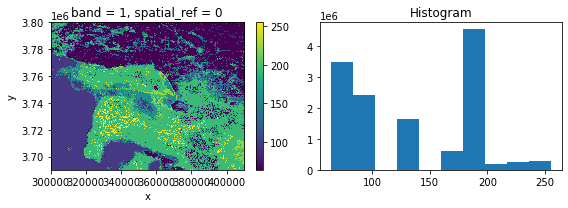

Good Quality Pixels =  [64, 68, 128, 132]


In [25]:
# Create path for the pixel_qa_layer for subdirectory scene
scene_pixel_qa_path = os.path.join(sent_path,
                                  "HLS.S30.T11SLT.2021008T183739.v2.0.Fmask.tif")

sent_qa = rxr.open_rasterio(scene_pixel_qa_path).squeeze()

#define valid values to be exluded from mask
goodQuality = cloud_mask(fmask = sent_qa)

#plot the QA layers to visualize masks 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
sent_qa.plot.imshow(ax=ax1)

plt.title("Fmask QA Layer for Sentinel-2 HLS; \n 11SLT (LA Region)")
sent_qa.plot.hist(ax=ax2)

plt.tight_layout()
plt.show()

print("Good Quality Pixels = ",goodQuality)


## Follow Sentinel-2 HLS documentation to create masking value references ## 

Git: https://git.earthdata.nasa.gov/projects/LPDUR/repos/hls-tutorial/browse/HLS_Tutorial.ipynb#processhls

## Testing Step: Visualize the Sentinel-2 bands outputs to validate data sources

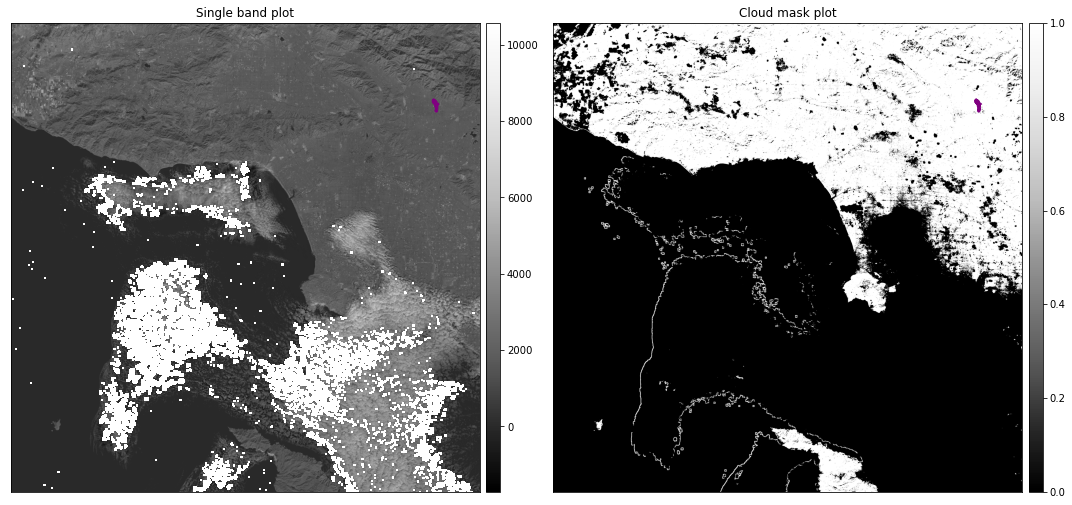

In [26]:

# #test ndmi
test_ndmi_xr = (test_rxr_8-test_rxr_11) / (test_rxr_8+test_rxr_11)

masked_test_8, cloud_mask_8 = open_clean_bands(test_tif_8, 
                                               crop_bound=la_reproj_crop,
                                               valid_range=(0,10000),
                                               pixel_qa_path=scene_pixel_qa_path)

# test single band raster plot and ndmi plots  
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ep.plot_bands(test_rxr_8,
              ax=ax1,
              extent=la_plot_extent,
              cbar="terrain_r",
             title = "Single band plot")

eaton_shape.plot(ax=ax1,
                       color='none',
                       linewidth = 3,
                       edgecolor = 'purple')

ep.plot_bands(cloud_mask_8.isin(goodQuality).squeeze(),
              ax=ax2,
              extent=la_plot_extent,
              cbar="terrain_r",
             title = "Cloud mask plot")

eaton_shape.plot(ax=ax2,
                color='none',
                linewidth = 3,
                edgecolor = 'purple')


plt.tight_layout()
plt.show()

In [27]:
proportion_2 = np.count_nonzero(~np.isnan(test_rxr_8))
proportion_1 = np.count_nonzero(~np.isnan(masked_test_8))

print(proportion_2)
print(proportion_1)

ratio = 1-(proportion_2 - proportion_1) / proportion_2
ratio

13099784
4342694


0.3315088248783339

## Core Analysis 1: Loop through Sentinel-2 HLS bands, calculate NDMI for project area ##

In [28]:
# Create loop to process a sample Sentinel-2 view 

eaton_ndmi_list = []    
for tifs in ndmi_band_paths:

    filename = os.path.normpath(tifs).split(os.sep)[-1]
    print("On",filename[-27:-20],"-",filename[-7:-4])
    site = tifs[-33:-28]
    olddate = tifs[-27:-20]
    band = tifs[-7:-4]

    datetimeobject = datetime.strptime(olddate,'%Y%j')
    date = datetimeobject.strftime('%m-%d-%Y')

#     list_of_sites = (eaton_shape, pasadena_shape)
    
#     for sites in list_of_sites:
#         area_name = sites
#         print ("Working on", sites)
    cleaned_sent = open_clean_bands(tifs,
                                    crop_bound=eaton_shape, 
                                    valid_range = (0,10000),
                                   pixel_qa_path=scene_pixel_qa_path)

    # create output 
    output = [date, band, cleaned_sent[0]]

    #append to list before df 
    eaton_ndmi_list.append(output)
    
#Convert list of cleaned arrays with date and band to df
eaton_ndmi_df = pd.DataFrame(eaton_ndmi_list,
                       columns = ["date","band", "array"]
                      ).sort_values(by=["date"])

eaton_indexed_df = eaton_ndmi_df.set_index("date")

#Calculate NDMI through normalized difference of band 8 and 11
eaton_mean_list = []
eaton_ndmi_arrays = []
for key, value in eaton_indexed_df.groupby(["date"]):
    #define bands and perform normalized diff for ndmi
    band_8 = value['array'][0]
    band_11 = value['array'][1]
    ndmi = (band_8-band_11) / (band_8+band_11)

    mean_ndmi = ndmi.mean(skipna=True).item()

    #Create outputs for mean ndmi list (and ndmi arrays just in case) 
    output_1 = [value.index[0], mean_ndmi]
    eaton_mean_list.append(output_1)
    output_2 = [date,ndmi]
    eaton_ndmi_arrays.append(output_2)
    

#Create dataframes for mean NDMI and NDMI arrays
eaton_mean_df = pd.DataFrame(eaton_mean_list,
                           columns = ["date","mean"])
eaton_mean_ndmi_df = eaton_mean_df.set_index("date")

eaton_ndmi_df = pd.DataFrame(eaton_ndmi_arrays,
                           columns = ["date","ndmi"])
# call mean NDMI dataframe                       
eaton_mean_ndmi_df

On 2021003 - B08
On 2021008 - B08
On 2021013 - B08
On 2021018 - B08
On 2021023 - B08
On 2021028 - B08
On 2021033 - B08
On 2021038 - B08
On 2021043 - B08
On 2021048 - B08
On 2021053 - B08
On 2021058 - B08
On 2021063 - B08
On 2021068 - B08
On 2021073 - B08
On 2021078 - B08
On 2021083 - B08
On 2021088 - B08
On 2021093 - B08
On 2021098 - B08
On 2021103 - B08
On 2021108 - B08
On 2021113 - B08
On 2021118 - B08
On 2021123 - B08
On 2021128 - B08
On 2021133 - B08
On 2021138 - B08
On 2021143 - B08
On 2021148 - B08
On 2021153 - B08
On 2021163 - B08
On 2021168 - B08
On 2021173 - B08
On 2021178 - B08
On 2021213 - B08
On 2021218 - B08
On 2021223 - B08
On 2021228 - B08
On 2021233 - B08
On 2021238 - B08
On 2021243 - B08
On 2021248 - B08
On 2021253 - B08
On 2021258 - B08
On 2021263 - B08
On 2021268 - B08
On 2021273 - B08
On 2021278 - B08
On 2021283 - B08
On 2021288 - B08
On 2021293 - B08
On 2021298 - B08
On 2021303 - B08
On 2021308 - B08
On 2021313 - B08
On 2021318 - B08
On 2021323 - B08
On 2021328 - B

,mean
date,
01-03-2021,0.002693
01-08-2021,-0.007519
01-13-2021,-0.035136
01-18-2021,-0.020370
01-23-2021,-0.686371
...,...
12-04-2021,0.026557
12-14-2021,-0.639551
12-19-2021,-0.023953


<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

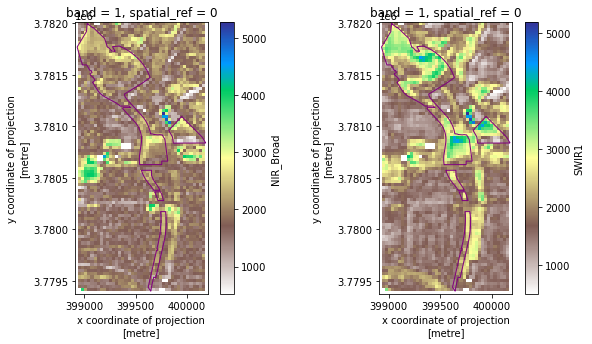

In [29]:
# testing that Bands 0 (8) and 1 (11) are valid
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

eaton_indexed_df['array'][0].plot.imshow(ax=ax1, 
                                    cmap = "terrain_r")
eaton_shape.plot(ax=ax1,
                 color='none',
                 linewidth = 1,
                 edgecolor = 'purple',
                 vmin=-1,
                 vmax=-1)

eaton_indexed_df['array'][1].plot.imshow(ax=ax2, 
                                    cmap = "terrain_r")
eaton_shape.plot(ax=ax2,
                 color='none',
                 linewidth = 1,
                 edgecolor = 'purple',
                 vmin=-1,
                 vmax=-1)

In [30]:
# # Create list of proportion of clean data in each tif

# clean_ndmi_list = []    
# for tifs in band_8_paths:
#     olddate = tifs[-27:-20]
#     print ("On", olddate)
#     band = tifs[-7:-4]

#     datetimeobject = datetime.strptime(olddate,'%Y%j')
#     date = datetimeobject.strftime('%m-%d-%Y')

#     cleaned_sent = open_clean_bands(tifs,
#                                     crop_bound=la_reproj_crop, 
#                                     valid_range = (0,10000),
#                                    pixel_qa_path=scene_pixel_qa_path)
    
#     proportion_2 = np.count_nonzero(~np.isnan(test_rxr_8))
#     proportion_1 = np.count_nonzero(~np.isnan(cleaned_sent))

#     ratio = 1-(proportion_2 - proportion_1) / proportion_2

#     # create output 
#     output = [date, ratio]

#     #append to list before df 
#     clean_ndmi_list.append(output)

# clean_ndmi_df = pd.DataFrame(clean_ndmi_list,
#                            columns = ["date","clean"])
# clean_ndmi_df_indexed = clean_ndmi_df.set_index("date")
# clean_ndmi_df_indexed

# clean_percent = clean_ndmi_df_indexed["clean"]
# eaton_mean_ndmi_df = eaton_mean_ndmi_df.join(clean_percent)


## Calculate Mean NDMI for Site Area (LA Metro) For Comparison ## 

In [16]:
la_ndmi_list = []    
for tifs in ndmi_band_paths:
  
    filename = os.path.normpath(tifs).split(os.sep)[-1]
    print("Looping through",filename[-27:-20],"-",filename[-7:-4])
    site = tifs[-33:-28]
    olddate = tifs[-27:-20]
    band = tifs[-7:-4]
    
    datetimeobject = datetime.strptime(olddate,'%Y%j')
    date = datetimeobject.strftime('%m-%d-%Y')
    
    cleaned_sent = open_clean_bands(tifs,
                                    crop_bound=pasadena_shape, 
                                    valid_range = (0,10000),
                                   pixel_qa_path=scene_pixel_qa_path)
    # create output 
    output = [date, band, cleaned_sent[0]]    # cleaned_sent[0] gathers just the band array, not the cloud mask

    #append to list before df 
    la_ndmi_list.append(output)
    

#Convert list of cleaned arrays with date and band to df
la_ndmi_df = pd.DataFrame(la_ndmi_list,
                       columns = ["date","band", "array"]
                      ).sort_values(by=["date"])
                                       
la_indexed_df = la_ndmi_df.set_index("date")

#Calculate NDMI through normalized difference of band 8 and 11
la_mean_list = []
la_ndmi_arrays = []

for key, value in la_indexed_df.groupby(["date"]):
    #define bands and perform normalized diff for ndmi
    band_8 = value['array'][0]
    band_11 = value['array'][1]
    ndmi = (band_8-band_11) / (band_8+band_11)
    
    mean_ndmi = ndmi.mean(skipna=True).item()
    
    #Create outputs for mean ndmi list (and ndmi arrays just in case) 
    output_1 = [value.index[0], mean_ndmi]
    la_mean_list.append(output_1)
    output_2 = [date,ndmi]
    la_ndmi_arrays.append(output_2)
    
#Create dataframes for mean NDMI and NDMI arrays
la_mean_df = pd.DataFrame(la_mean_list,
                           columns = ["date","mean"])
la_mean_ndmi_df = la_mean_df.set_index("date")

la_ndmi_df = pd.DataFrame(la_ndmi_arrays,
                           columns = ["date","ndmi"])

# call mean NDMI dataframe                       
la_mean_ndmi_df

Looping through 2021003 - B08
Looping through 2021008 - B08
Looping through 2021013 - B08
Looping through 2021018 - B08
Looping through 2021023 - B08
Looping through 2021028 - B08
Looping through 2021033 - B08
Looping through 2021038 - B08
Looping through 2021043 - B08
Looping through 2021048 - B08
Looping through 2021053 - B08
Looping through 2021058 - B08
Looping through 2021063 - B08
Looping through 2021068 - B08
Looping through 2021073 - B08
Looping through 2021078 - B08
Looping through 2021083 - B08
Looping through 2021088 - B08
Looping through 2021093 - B08
Looping through 2021098 - B08
Looping through 2021103 - B08
Looping through 2021108 - B08
Looping through 2021113 - B08
Looping through 2021118 - B08
Looping through 2021123 - B08
Looping through 2021128 - B08
Looping through 2021133 - B08
Looping through 2021138 - B08
Looping through 2021143 - B08
Looping through 2021148 - B08
Looping through 2021153 - B08
Looping through 2021163 - B08
Looping through 2021168 - B08
Looping th

,mean
date,
01-03-2021,0.104343
01-08-2021,0.088435
01-13-2021,-0.105612
01-18-2021,0.074191
01-23-2021,-0.622718
...,...
12-04-2021,-0.006393
12-14-2021,-0.595980
12-19-2021,-0.068344


## Plot NDMI with Project Area (Eaton Spreading Grounds) Boundaries ##

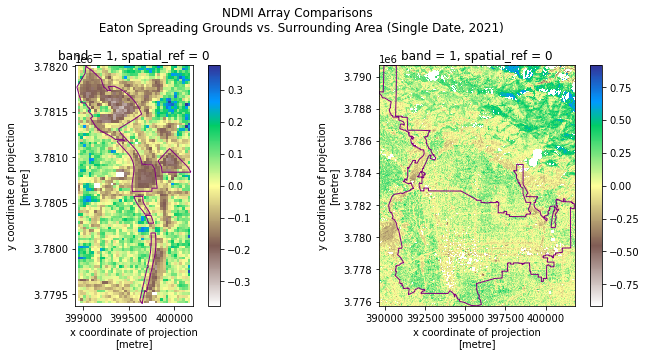

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

eaton_ndmi_df["ndmi"][0].plot.imshow(ax=ax1, 
                                    cmap = "terrain_r")
eaton_shape.plot(ax=ax1,
                 color='none',
                 linewidth = 1,
                 edgecolor = 'purple',
                 vmin=-1,
                 vmax=-1)

la_ndmi_df["ndmi"][0].plot.imshow(ax=ax2,
                                 cmap = "terrain_r")
pasadena_shape.plot(ax=ax2,
                color='none',
                linewidth = 1,
                edgecolor = 'purple',
                vmin=-1,
                vmax=-1)

plt.suptitle("NDMI Array Comparisons \n Eaton Spreading Grounds vs. Surrounding Area (Single Date, 2021)")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, '2021 Comparison of NDMI \n Eaton Spreading Grounds vs Surrounding Area (Pasadena) ')

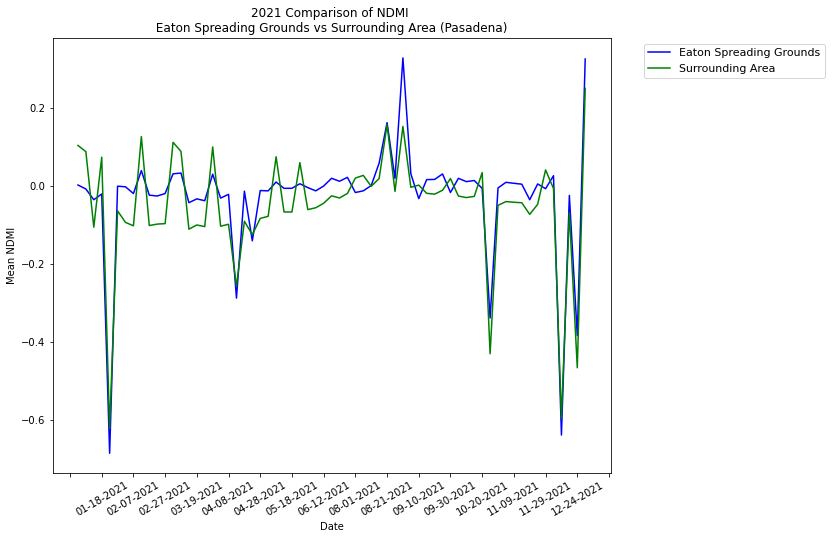

In [36]:
fig, ax = plt.subplots(figsize=(10,8)) #consider a qqplot or probplot?

ax.plot(eaton_mean_ndmi_df.index, 
                  eaton_mean_ndmi_df["mean"],
        label="Eaton Spreading Grounds",
                  color="blue")

ax.plot(la_mean_ndmi_df.index, 
                  la_mean_ndmi_df["mean"],
        label="Surrounding Area",
                  color="green")

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
          prop={'size': 11})

ax.set(xlabel = "Date",
       ylabel = "Mean NDMI")

plt.setp(ax.get_xticklabels(), rotation = 30)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))


plt.title("2021 Comparison of NDMI \n Eaton Spreading Grounds vs Surrounding Area (Pasadena) ")

(array([121., 636., 625., 600., 505., 417., 371., 209.,  57.,   6.]),
 array([-0.81623781, -0.78279261, -0.74934741, -0.71590221, -0.68245701,
        -0.64901181, -0.61556661, -0.58212141, -0.54867621, -0.51523101,
        -0.48178581]),
 <BarContainer object of 10 artists>)

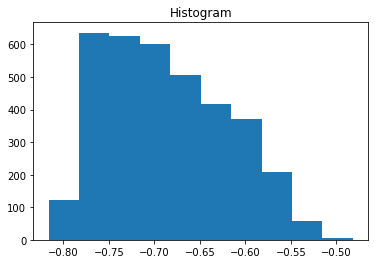

In [33]:
eaton_ndmi_df["ndmi"][4].plot.hist()

(array([ 2444.,  2691.,  1773.,  4417., 10228., 48890., 88244., 55866.,
         9949.,  5081.]),
 array([-0.84197428, -0.71376031, -0.58554634, -0.45733237, -0.3291184 ,
        -0.20090443, -0.07269046,  0.05552351,  0.18373748,  0.31195145,
         0.44016542]),
 <BarContainer object of 10 artists>)

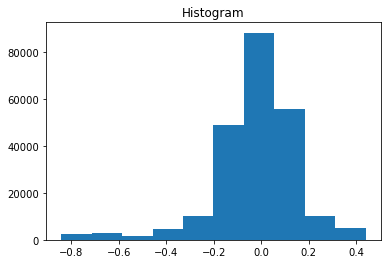

In [34]:
xr.concat(eaton_ndmi_df["ndmi"],dim="time").plot.hist()

In [35]:
!jupyter nbconvert --to html  --no-input ea-capstone-workbook-2022.ipynb

[NbConvertApp] Converting notebook ea-capstone-workbook-2022.ipynb to html
[NbConvertApp] Writing 1826301 bytes to ea-capstone-workbook-2022.html


# Data Sources 

- Sentinel-2 HLS Data: https://search.earthdata.nasa.gov/search
- City of Los Angeles Open Data: https://data.lacity.org/
- City of Los Angeles GeoHub: https://geohub.lacity.org/ 